# Non-negative matrix factorization

Reference: [Non-negative matrix factorization](http://scikit-learn.org/stable/modules/decomposition.html#non-negative-matrix-factorization-nmf-or-nnmf)

NMF is an alternative approach to decomposition that assumes that the data and the components are non-negative. NMF can be plugged in instead of PCA or its variants, in the cases where the data matrix does not contain negative values. It finds a decomposition of samples X into two matrices W and H of non-negative elements, by optimizing for the squared Frobenius norm:

\arg\min_{W,H} \frac{1}{2} ||X - WH||_{Fro}^2 = \frac{1}{2} \sum_{i,j} (X_{ij} - {WH}_{ij})^2

This norm is an obvious extension of the Euclidean norm to matrices. (Other optimization objectives have been suggested in the NMF literature, in particular Kullback-Leibler divergence, but these are not currently implemented.)

Using: [sklearn.decomposition.NMF](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html)

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os, sys
import numpy as np
from skimage import io
import matplotlib.pylab as plt
import notebooks.notebook_utils as uts

:0: FutureWarning: IPython widgets are experimental and may change in the future.


## load datset

loading dataset: (True) exists -> /mnt/30C0201EC01FE8BC/TEMP/atomicPatternDictionary_v0/datasetProb_raw
loading (True) <- /mnt/30C0201EC01FE8BC/TEMP/atomicPatternDictionary_v0/dictionary/atlas.png


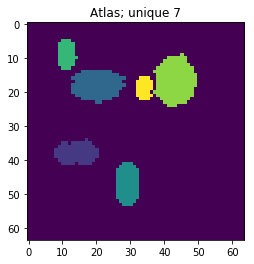

In [2]:
p_dataset = os.path.join(uts.DEFAULT_PATH, uts.DATSETS_PROB[0])
print 'loading dataset: ({}) exists -> {}'.format(os.path.exists(p_dataset), p_dataset)

p_atlas = os.path.join(uts.DEFAULT_PATH, 'dictionary/atlas.png')
atlas_gt = io.imread(p_atlas)
nb_patterns = len(np.unique(atlas_gt))
print 'loading ({}) <- {}'.format(os.path.exists(p_atlas), p_atlas)
_ = plt.imshow(atlas_gt, interpolation='nearest')
_ = plt.title('Atlas; unique %i' % nb_patterns)

In [3]:
lImgs = uts.load_dataset(p_dataset)
print 'loaded # images: ', len(lImgs)
imShape = lImgs[0].shape
print 'image shape:', imShape

loaded # images:  800
image shape: (64, 64)


## Pre-Processing

input data shape: (800, 4096)


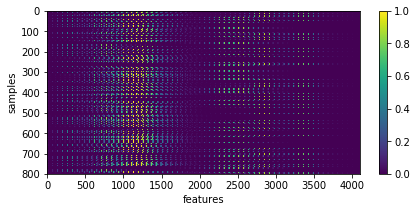

In [5]:
X = np.array([im.ravel() for im in lImgs])  # - 0.5
print 'input data shape:', X.shape

plt.figure(figsize=(7, 3))
_= plt.imshow(X, aspect='auto'), plt.xlabel('features'), plt.ylabel('samples'), plt.colorbar()

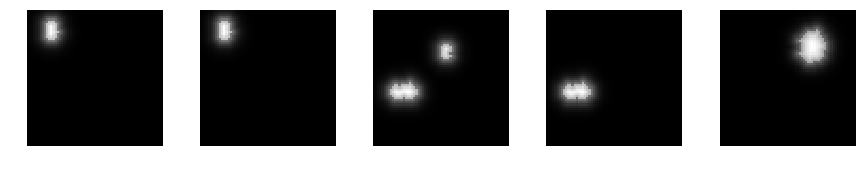

In [6]:
uts.show_sample_data_as_imgs(X, imShape, nb_rows=1, nb_cols=5)

## Non-negative matrix factorization

In [7]:
from sklearn.decomposition import NMF
nmf = NMF(n_components=nb_patterns, max_iter=99)

X_new = nmf.fit_transform(X[:1200,:])
print 'fitting parameters:', nmf.get_params()
print 'number of iteration:', nmf.n_iter_

fitting parameters: {'beta_loss': 'frobenius', 'shuffle': False, 'verbose': 0, 'solver': 'cd', 'l1_ratio': 0.0, 'max_iter': 99, 'init': None, 'random_state': None, 'n_components': 7, 'tol': 0.0001, 'alpha': 0.0}
number of iteration: 98


**show the estimated components - dictionary**

estimated component matrix: (7, 4096)


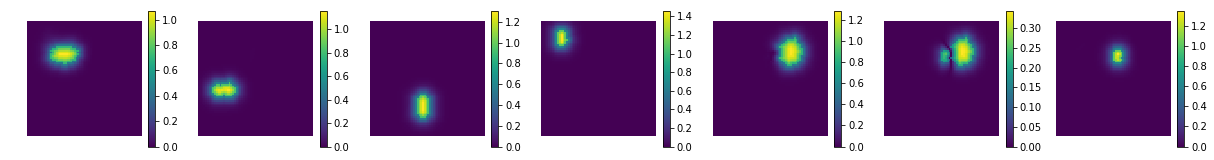

In [8]:
comp = nmf.components_
coefs = np.sum(np.abs(X_new), axis=0)
print 'estimated component matrix:', comp.shape

compSorted = [c[0] for c in sorted(zip(comp, coefs), key=lambda x: x[1], reverse=True) ]
uts.show_sample_data_as_imgs(np.array(compSorted), imShape, nb_cols=nb_patterns, bool_clr=True)

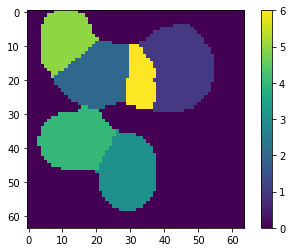

In [9]:
ptn_used = np.sum(np.abs(X_new), axis=0) > 0
atlas_ptns = comp[ptn_used, :].reshape((-1, ) + lImgs[0].shape)

atlas_ptns = comp.reshape((-1, ) + lImgs[0].shape)
atlas_estim = np.argmax(atlas_ptns, axis=0) + 1
atlas_sum = np.sum(np.abs(atlas_ptns), axis=0)
atlas_estim[atlas_sum < 1e-1] = 0
_ = plt.imshow(atlas_estim, interpolation='nearest'), plt.colorbar()

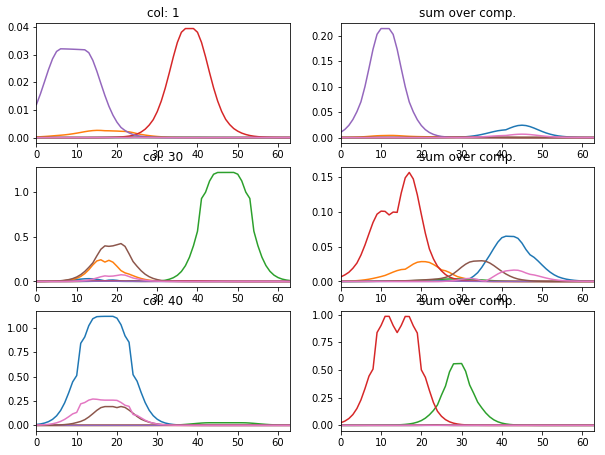

In [12]:
l_idx = [1, 30, 40]
fig, axr = plt.subplots(len(l_idx), 2, figsize=(10, 2.5 * len(l_idx)))
for i, idx in enumerate(l_idx):
    axr[i, 0].plot(atlas_ptns[:,:,idx].T), axr[i, 0].set_xlim([0, 63])
    axr[i, 0].set_title('col: {}'.format(idx))
    axr[i, 1].plot(np.abs(atlas_ptns[:,idx,:].T)), axr[i, 1].set_xlim([0, 63])
    axr[i, 1].set_title('sum over comp.')

**particular coding of each sample**

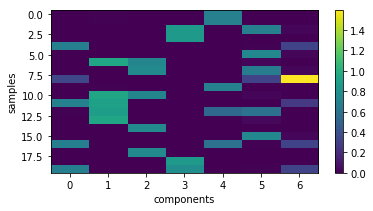

In [16]:
plt.figure(figsize=(6, 3))
_= plt.imshow(X_new[:20,:], interpolation='nearest', aspect='auto'), plt.colorbar()
_= plt.xlabel('components'), plt.ylabel('samples')

coefs = np.sum(np.abs(X_new), axis=0)
# print 'used coeficients:', coefs.tolist()

**backword reconstruction from encoding and dictionary**

In [17]:
res = np.dot(X_new, comp)
print 'model applies by reverting the unmixing', res.shape

model applies by reverting the unmixing (200, 4096)


model applies by reverting the unmixing (800, 4096)


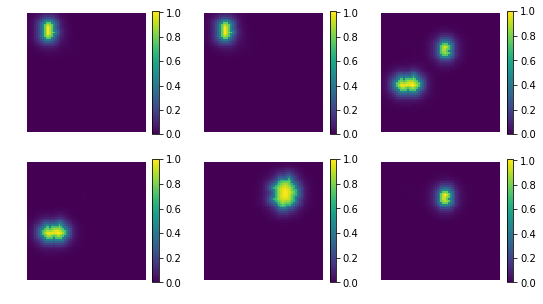

In [20]:
uts.show_sample_data_as_imgs(res, imShape, nb_rows=2, nb_cols=3, bool_clr=True)